# Malaria Detector

---

## Motivation
[Malaria](https://en.wikipedia.org/wiki/Malaria) is a deadly parasitic disease carried by Anopheles mosquitoes. This disease is prevalent across the globe, especially in tropical regions.

When someone is infected, the parasites will get in their blood and start destroying oxygen-carrying RBCs (red blood cells), the parasites can live dormant in your body for over a year without any issue, and once symptoms occur a delay in the proper treatment can lead to complications and even death, what's worse, it's easy to confuse the first symptoms of the disease with a mere flu.

The World Health Organization (WHO) has released several [crucial facts on malaria](https://www.who.int/news-room/facts-in-pictures/detail/malaria). In short, nearly half the world’s population is at risk from malaria and there are over 200 million malaria cases and approximately 400,000 deaths due to malaria every year. This brings all the more motivation to make malaria detection and diagnosis fast, easy and effective.

Nowadays malaria detection is an intensive manual process, which consists on intensive examination of the blood smear at a 100x magnification, where people manually count red blood cells that contain parasites out of 5000 cells.

> Thick blood smears assist in detecting the presence of parasites while thin blood smears assist in identifying the species of the parasite causing the infection (Centers for Disease Control and Prevention, 2012). The diagnostic accuracy heavily depends on human expertise and can be adversely impacted by the inter-observer variability and the liability imposed by large-scale diagnoses in disease-endemic/resource-constrained regions (Mitiku, Mengistu & Gelaw, 2003). Alternative techniques such as polymerase chain reaction (PCR) and rapid diagnostic tests (RDT) are used; however, PCR analysis is limited in its performance (Hommelsheim et al., 2014) and RDTs are less cost-effective in disease-endemic regions (Hawkes, Katsuva & Masumbuko, 2009).

## Data Source
The source of this data is from the public [Malaria Cell Images Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) from [Kaggle](https://www.kaggle.com). The dataset was carefully collected and annotated by researchers at the Lister Hill National Center for Biomedical Communications (LHNCBC).

They developed a mobile application that runs on a standard Android smartphone that can be attached to a conventional light microscope (Poostchi et al., 2018). The smartphone’s built-in camera acquired images of slides for each microscopic field of view. The images were manually annotated by an expert slide reader at the Mahidol-Oxford Tropical Medicine Research Unit in Bangkok, Thailand.

The downloaded dataset is composed of zipped folders that contain red cell images captured from blood smear tests, the folders separate which cells are infected with [Malaria](https://en.wikipedia.org/wiki/Malaria) and which are not infected by the disease.

## Previous Work
Since this is a public dataset, multiple people have iterated on solutions to it, the following works were used as foundations for this project:
- [Kaggle/slvdev Malaria - Classification Problem | Keras | CNN | 97%](https://www.kaggle.com/slvdev/malaria-classification-problem-keras-cnn-97)
- [Towardsdatascience - Detecting Malaria with Deep Learning](https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60)

## Disclaimer
Although the [Coursera - Advanced Data Science with IBM Specialization](https://www.coursera.org/specializations/advanced-data-science-ibm#about) taught me the power of IBM Watson Studio, due to the nature of this dataset, not only the required RAM to work with this project exceeded the one available in the IBM Watson free tier, but also training would've been quite slow working with the CPUs available in the free tier.

That's why after a few memory crashes I ended up developing the project in my local environment with `Python 3.7.5`. This notebook along with the dataset and a `requirements.txt` file to install all the required libraries in the virtual environment can be found at [this GitHub repository](https://github.com/xmartlabs/malaria-detector).

---
## Install dependencies

In [1]:
import os # To handle paths
import glob # Unix style pathname pattern expansion
import re

import numpy as np
np.random.seed(42)
import pandas as pd
import cv2 # To process images

from concurrent import futures
import threading

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # encode text category labels
from sklearn import metrics
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)

---
## Malaria Cells Images ETL

### Extract images from assets

This dataset is composed of images stored in two folders, inside `Uninfected` are images of cells that aren't infected with Malaria, where as in `Parasitized` are blood cells that are infected with the parasitic disease.

The first stage is to get all these image paths into a pandas DataFrame, so we can read all those images to memory

In [2]:
ROOT_DATA_DIR = './cell_images'

INFECTED_DIR = os.path.join(ROOT_DATA_DIR, 'Parasitized')
UNINFECTED_DIR = os.path.join(ROOT_DATA_DIR, 'Uninfected')

infected_files = glob.glob(INFECTED_DIR+'/*.png')
uninfected_files = glob.glob(UNINFECTED_DIR+'/*.png')

print(f'Amount of parasitized images: {len(infected_files)}')
print(f'Amount of uninfected images: {len(uninfected_files)}')
print(f'Total Images: {len(infected_files) + len(uninfected_files)}')

Amount of parasitized images: 13779
Amount of uninfected images: 13779
Total Images: 27558


In [3]:
classified_infected_files = [(infected_file, 'infected') for infected_file in infected_files]
classified_uninfected_files = [(uninfected_file, 'uninfected') for uninfected_file in uninfected_files]

df_pandas = pd.DataFrame(classified_infected_files + classified_uninfected_files, columns = ['filename', 'label']).sample(frac=1, random_state=42).reset_index(drop=True)

df_pandas.head()

,filename,label
0,./cell_images/Parasitized/C89P50ThinF_IMG_2015...,infected
1,./cell_images/Parasitized/C84P45ThinF_IMG_2015...,infected
2,./cell_images/Uninfected/C238NThinF_IMG_201512...,uninfected
3,./cell_images/Uninfected/C213ThinF_IMG_2015110...,uninfected
4,./cell_images/Uninfected/C121P82ThinF_IMG_2015...,uninfected


### Build and Explore Image Datasets

To build deep learning models we need training data but we also need to test the model’s performance on unseen data. It was decided to use a 60:20:20 split for train, validatation and test datasets respectively. We will leverage the train and validation datasets during training and check the performance of the model on the test dataset.

In [4]:
train_files, test_files, train_labels, test_labels = train_test_split(df_pandas['filename'].values,
                                                                      df_pandas['label'].values, 
                                                                      test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.25, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(16534,) (5512,) (5512,)
Train: Counter({'infected': 8276, 'uninfected': 8258}) 
Val: Counter({'uninfected': 2808, 'infected': 2704}) 
Test: Counter({'infected': 2799, 'uninfected': 2713})


This particular dataset has the issue that the images aren't all of equal size, let's analyze how data is distributed.

In [5]:
def get_img_shape(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('Working on img num: {}'.format(idx))
    return cv2.imread(img).shape

train_data_input = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]

print('Starting Img shape computation:')
train_img_dims = [get_img_shape(record[0], record[1], record[2]) for record in train_data_input]

print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

train_img_dims = None

Starting Img shape computation:
Working on img num: 0
Working on img num: 5000
Working on img num: 10000
Working on img num: 15000
Working on img num: 16533
Min Dimensions: [40 49  3]
Avg Dimensions: [132.96044514 132.44786501   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 265   3]


Taking the data into account 125x125px sounds like a reasonable shape to resize the images.

Parallel processing is applied to speed up the image read operations.

In [6]:
IMG_DIMS = (125, 125)
ex = futures.ThreadPoolExecutor(max_workers=None)

def get_img_data(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('Working on img num: {}'.format(idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

def get_data_parallel(files, title):
    print(f'Loading {title} Images:')
    data_input = [(idx, img, len(files)) for idx, img in enumerate(files)]
    data_map = ex.map(get_img_data, 
                        [record[0] for record in data_input],
                        [record[1] for record in data_input],
                        [record[2] for record in data_input])
    return np.array(list(data_map))

In [7]:
train_data = get_data_parallel(train_files, 'Train')
print('')
val_data = get_data_parallel(val_files, 'Validation')

train_data.shape, val_data.shape 

Loading Train Images:
Working on img num: 0
Working on img num: 5000
Working on img num: 10000
Working on img num: 15000
Working on img num: 16533

Loading Validation Images:
Working on img num: 0
Working on img num: 5000
Working on img num: 5511


((16534, 125, 125, 3), (5512, 125, 125, 3))

### Plotting

Let's visualize the data by randomly sampling the training set.

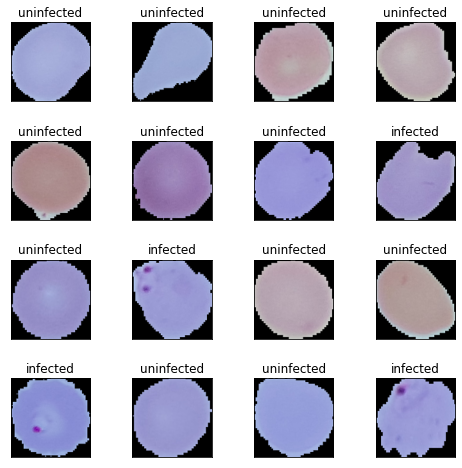

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

### Encoding

We encode the labels to allow for binary classification.

In [9]:
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform(test_labels)

print(train_labels[:6], train_labels_enc[:6])

['uninfected' 'infected' 'infected' 'infected' 'infected' 'infected'] [1 0 0 0 0 0]


### Data Augmentation

When working with Image Classification problems, they usually require really deep networks that are hard to train since they require a lot of data in order not to overfit, that's why is a common practice to apply data augmentation, creating new samples by applying transformations to the labeled images in the dataset.

Since the dataset weight quite a lot it's also desired to stream the images to the network rather than having all in memory at the same time, that's where the [Keras ImageDataGenerator](https://keras.io/preprocessing/image/) comes in.

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Let's take a random sample of these transformations.

Labels: ['uninfected', 'uninfected', 'uninfected', 'uninfected', 'uninfected']


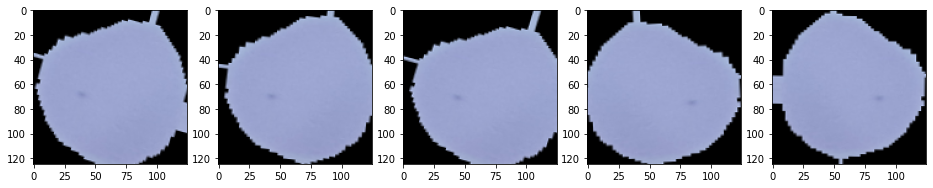

In [11]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1], batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

We create the train and val generators, by taking into account training will be done with a batch size of 64.

In [12]:
BATCH_SIZE = 64

train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

train_data, train_labels, val_data, val_labels = (None, None, None, None)

---
## Model Definition and Training

For the experimentation we'll take the CNN presented on [Kaggle/slvdev Malaria - Classification Problem | Keras | CNN | 97%](https://www.kaggle.com/slvdev/malaria-classification-problem-keras-cnn-97) as baseline, then as we'll see if Transfer Learning has better performance than a CNN built from scratch. However, instead of using the [VGG-19](https://www.mathworks.com/help/deeplearning/ref/vgg19.html) (which was introduced in [2014](https://arxiv.org/abs/1409.1556)) as [Towardsdatascience - Detecting Malaria with Deep Learning](https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60) did, we'll experiment on how [Inception V3](https://www.mathworks.com/help/deeplearning/ref/inceptionv3.html) fares as backbone. 

> Transfer learning is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones.

Humans don't learn everything from the ground up and leverage and transfer their knowledge from previously learnt domains to newer domains and tasks.

> If data is currency, then transfer learning is a messiah for the poors.

The objective of Transfer Learning is to take advantage of data from the ﬁrst setting to extract information that may be useful when learning or even when directly making predictions in the second setting

Getting a dataset for every domain is tough. Besides, most deep learning models are very specialized to a particular domain or even a specific task. While these might be state-of-the-art models, with really high accuracy and beating all benchmarks, it would be only on very specific datasets and end up suffering a significant loss in performance when used in a new task which might still be similar to the one it was trained on.

This forms the motivation for transfer learning, which goes beyond specific tasks and domains, and tries to see how to leverage knowledge from pre-trained models and use it to solve new problems!

When doing Transfer Learning there are two things to consider:
- Do we freeze training on all layers in the backbone model? or modify the weights for the last layers as part of the training? (Frozen vs Fine-Tuned)
- Do we connect the backbone model directly to the outer layer? or connect it to a set of hidden MLP layers?

Taking this into account, it makes sense to experiment which combination of these options work better for this dataset, that's why we'll train 4 models and evaluate which works best for this input.

In [13]:
# Define constants for training
EPOCHS = 30
INPUT_SHAPE = (*IMG_DIMS, 3)

### Training Helpers

In [14]:
def train(model=None, save_as=None):
    """
        Adds callbacks and trains the model
        
        Parameters
        ----------
        model : Model
            A Keras Model.
        save_as : string
            Filename with which the trained model will be saved
            
        Returns
        -------
        History
            Its `History.history` attribute is a record of training loss values and metrics values
            at successive epochs, as well as validation loss values and validation metrics values.
    """
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=15, 
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )
    callbacks = [reduce_lr, early_stop]

    train_steps_per_epoch = train_generator.n // train_generator.batch_size
    val_steps_per_epoch = val_generator.n // val_generator.batch_size

    history = model.fit(
        train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS, callbacks=callbacks,
        validation_data=val_generator, validation_steps=val_steps_per_epoch, verbose=1
    )

    model.save(f'models/{save_as}')
    return history

def plot_training_results(history=None, model_name='Model'):
    """
        Plots the History of a trained model
        
        Parameters
        ----------
        history : History
            A Keras History object.
        model_name : string
            Model name for the title in the plot.
    """
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(f"{model_name} Performance", fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    
    max_epoch = len(history.history['acc'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")
    
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 1))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

### Simple Convolutional Network

#### Model Definition

In [15]:
basic_cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

basic_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

basic_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 258 steps, validate for 86 steps
Epoch 1/2
258/258 [==============================] - 87s 339ms/step - loss: 0.3751 - acc: 0.8574 - val_loss: 3.6981 - val_acc: 0.5096
Epoch 2/2
258/258 [==============================] - 90s 348ms/step - loss: 0.1829 - acc: 0.9372 - val_loss: 0.2078 - val_acc: 0.9255


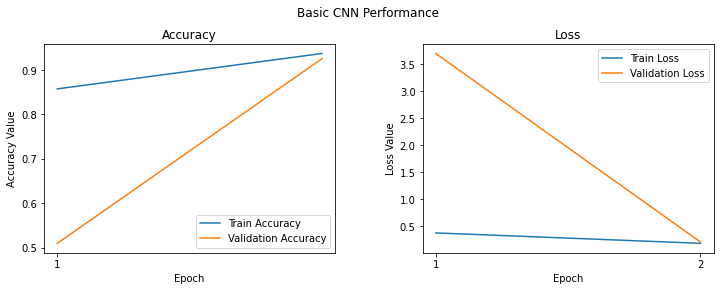

In [16]:
results = train(model=basic_cnn_model, save_as='test_basic_convolutional_neural_network_model.h5')
plot_training_results(history=results, model_name='Basic CNN')

### Transfer Learning with Inception v3

#### Model Architecture Helper

In [17]:
def inception_v3_build(freeze_weights=True, flatten_and_dense_layers=True):
    """
        Builds a model using Inception V3 as the foundations for transfer learning.
        
        Parameters
        ----------
        freeze_weights : Boolean
            True: Freeze the weights for all layers of Inception V3
            False: Freeze the weight for all layers of Inception V3 except the last 5.
        
        flatten_and_dense_layers : Boolean
            True: Inception Pooling is set to None, adds a Flatten layer, and
                  connects the Inception base model to two dense hidden layers.
            False: Inception Pooling is set to avg, connects the Inception layer
                   directly to the output sigmoid layer.
            
        Returns
        -------
        Keras.Model.Secuential
            A Secuential Keras Model which foundations are an Inception V3 model with the imagenet weights.
    """

    inception_v3_model = tf.keras.applications.inception_v3.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE,
        pooling=(None if flatten_and_dense_layers else 'avg')
    )

    # Freeze the layers
    if freeze_weights:
        inception_v3_model.trainable = False
    else:
        for layer in inception_v3_model.layers:
            layer.trainable = False
        for layer in inception_v3_model.layers[-5:]:
            layer.trainable = True

    # Build Sequential Model
    base_inception = inception_v3_model
    base_out = base_inception.output
    
    if flatten_and_dense_layers:
        pool_out = tf.keras.layers.Flatten()(base_out)
        hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
        drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
        hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
        drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

        out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)
    else:
        out = tf.keras.layers.Dense(1, activation='sigmoid')(base_out)

    inception_v3_model = tf.keras.Model(inputs=base_inception.input, outputs=out)
    inception_v3_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=5e-5),
                               loss='binary_crossentropy',
                               metrics=['acc'])

    inception_v3_model.summary()
    return inception_v3_model

#### Transfer Learning with Frozen Weights

In [18]:
inception_v3_frozen_model = inception_v3_build(freeze_weights=True, flatten_and_dense_layers=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 62, 62, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 62, 62, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 62, 62, 32)   0           batch_normalization_6[0][0]      
______________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 258 steps, validate for 86 steps
Epoch 1/2
258/258 [==============================] - 116s 450ms/step - loss: 0.4795 - acc: 0.7790 - val_loss: 0.5328 - val_acc: 0.8121
Epoch 2/2
258/258 [==============================] - 101s 391ms/step - loss: 0.3922 - acc: 0.8323 - val_loss: 0.4375 - val_acc: 0.8703


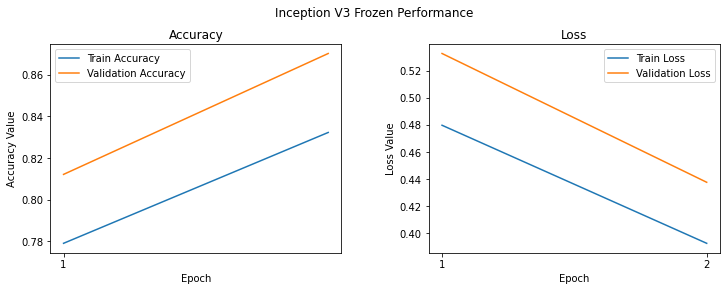

In [19]:
results = train(model=inception_v3_frozen_model, save_as='test_inception_v3_frozen_model.h5')
plot_training_results(history=results, model_name='Inception V3 Frozen')

#### Transfer Learning with Fine-Tuned Weights

In [20]:
inception_v3_fine_tuned_model = inception_v3_build(freeze_weights=False, flatten_and_dense_layers=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 62, 62, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 62, 62, 32)   96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 62, 62, 32)   0           batch_normalization_100[0][0]    
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 258 steps, validate for 86 steps
Epoch 1/2
258/258 [==============================] - 113s 437ms/step - loss: 0.4951 - acc: 0.7702 - val_loss: 0.4682 - val_acc: 0.8269
Epoch 2/2
258/258 [==============================] - 100s 387ms/step - loss: 0.3941 - acc: 0.8315 - val_loss: 0.5824 - val_acc: 0.7974


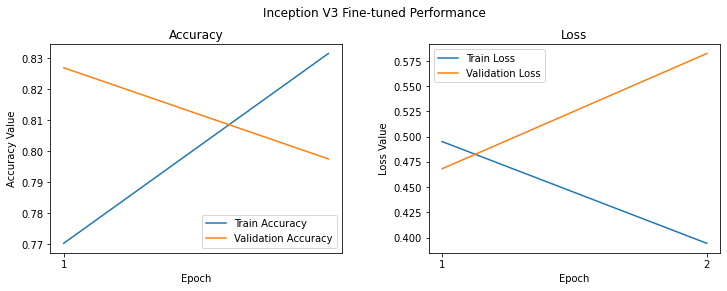

In [21]:
results = train(model=inception_v3_fine_tuned_model, save_as='test_inception_v3_fine_tuned_model.h5')
plot_training_results(history=results, model_name='Inception V3 Fine-tuned')

#### Transfer Learning without a hidden dense layer and with Frozen Weights

In [22]:
inception_v3_no_dense_frozen_model = inception_v3_build(freeze_weights=True, flatten_and_dense_layers=False)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 62, 62, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, 62, 62, 32)   96          conv2d_192[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 62, 62, 32)   0           batch_normalization_194[0][0]    
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 258 steps, validate for 86 steps
Epoch 1/2
258/258 [==============================] - 96s 372ms/step - loss: 0.6694 - acc: 0.5907 - val_loss: 0.7504 - val_acc: 0.5974
Epoch 2/2
258/258 [==============================] - 94s 363ms/step - loss: 0.5978 - acc: 0.6904 - val_loss: 0.6488 - val_acc: 0.6681


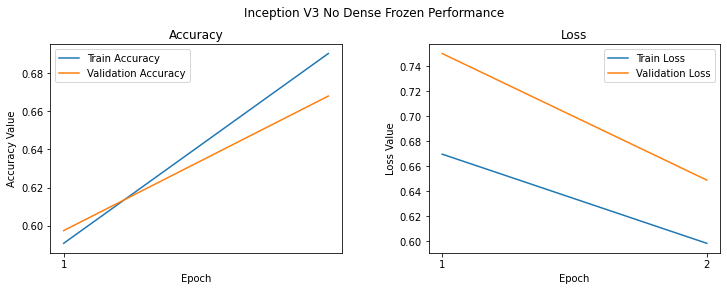

In [23]:
results = train(model=inception_v3_no_dense_frozen_model, save_as='test_inception_v3_no_dense_frozen_model.h5')
plot_training_results(history=results, model_name='Inception V3 No Dense Frozen')

#### Transfer Learning without a hidden dense layer and with Fine-Tuned Weights

In [24]:
inception_v3_no_dense_fine_tuned_model = inception_v3_build(freeze_weights=False, flatten_and_dense_layers=False)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d_286 (Conv2D)             (None, 62, 62, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_288 (BatchN (None, 62, 62, 32)   96          conv2d_286[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 62, 62, 32)   0           batch_normalization_288[0][0]    
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 258 steps, validate for 86 steps
Epoch 1/2
258/258 [==============================] - 96s 372ms/step - loss: 0.6432 - acc: 0.6288 - val_loss: 0.5561 - val_acc: 0.7184
Epoch 2/2
258/258 [==============================] - 93s 359ms/step - loss: 0.5796 - acc: 0.7145 - val_loss: 0.4930 - val_acc: 0.7567


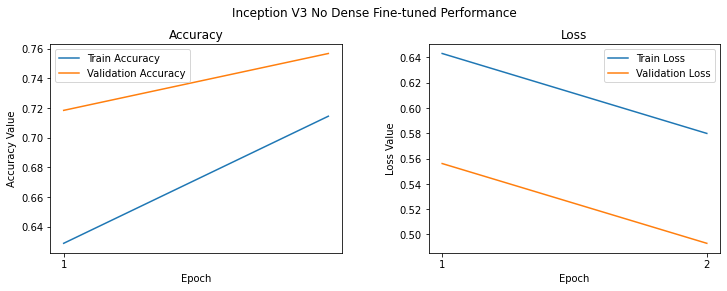

In [25]:
results = train(model=inception_v3_no_dense_fine_tuned_model, save_as='test_inception_v3_no_dense_fine_tuned_model.h5')
plot_training_results(history=results, model_name='Inception V3 No Dense Fine-tuned')

---
## Evaluation

Just by looking at the train and validation accuracy, we see that models that used Inception V3 as backbone performed quite poorly when compared to the Basic CNN from scratch.

Through the course of this project multiple things were tried, such as reducing the learning rate, while increasing the epochs and adding early stopping, however there wasn't a Inception V3 transfer learning model which accuracy surpassed 0.90

### Evaluator Helpers

In [26]:
def get_metrics(true_labels, predicted_labels):
    """
        Calculates the Accuracy, Precision, Recall and F1 of the validation results.
        
        Parameters
        ----------
        true_labels : List
        predicted_labels: List
            
        Returns
        -------
        Dictionary
            Accuracy, Precision, Recall, F1 Score
    """
    
    return {
        'Accuracy': np.round(metrics.accuracy_score(true_labels, predicted_labels), 4),
        'Precision': np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4),
        'Recall': np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4),
        'F1 Score:': np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4)
    }

def get_model_title(model_file):
    """
        Parses a filename to the title of the model.
        
        Example
        -------
        ./basic_cnn_model.h5 -> Basic CNN
        
        Parameters
        ----------
        model_file : String
            
        Returns
        -------
        String
            Title of the model
    """
    return(re.sub('_', ' ', re.match(r'./models/(.*)_model.h5', model_file).groups()[0]).title())

### Load Test Images

In [27]:
BATCH_SIZE = 64

# Process test dataset
test_data = get_data_parallel(test_files, 'Test')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_data, test_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

test_data, test_labels_enc = (None, None)

Loading Test Images:
Working on img num: 0
Working on img num: 5000
Working on img num: 5511


### Results

In [28]:
# Load Saved Deep Learning Models
saved_models = glob.glob('./models/*.h5')
models = map(tf.keras.models.load_model, saved_models)

# Make Predictions on Test Data
predictions = [model.predict(test_generator) for model in models]
predicted_labels = [le.inverse_transform([1 if prediction > 0.5 else 0
                                           for prediction in prediction.ravel()])
                     for prediction in predictions]

# Calculate metrics for all predicted data
metrics = [get_metrics(test_labels, pred_labels) for pred_labels in predicted_labels]

# Display Results
pd.DataFrame(metrics, index=map(get_model_title, saved_models))

,Accuracy,Precision,Recall,F1 Score:
Inception V3 Fine Tuned,0.8251,0.8259,0.8251,0.8249
Inception V3 Frozen,0.8696,0.8710,0.8696,0.8695
Test Inception V3 Fine Tuned,0.7995,0.8087,0.7995,0.7977
Inception V3 No Dense Frozen,0.8374,0.8393,0.8374,0.8373
Test Basic Convolutional Neural Network,0.9285,0.9346,0.9285,0.9283
Basic Convolutional Neural Network,0.9699,0.9702,0.9699,0.9699
Test Inception V3 Frozen,0.8634,0.8665,0.8634,0.8632
Inception V3 No Dense Fine Tuned,0.8284,0.8313,0.8284,0.8281
Test Inception V3 No Dense Fine Tuned,0.7609,0.7609,0.7609,0.7608
Test Inception V3 No Dense Frozen,0.6606,0.6816,0.6606,0.6521


---
## Conclusion

Indeed as we guessed with the training and validations sets, the Baseline model reached 0.97 F1 Score with the test set (as it achieved on [Kaggle/slvdev Malaria - Classification Problem | Keras | CNN | 97%](https://www.kaggle.com/slvdev/malaria-classification-problem-keras-cnn-97))

But the Inception V3 model wasn't as good as a backbone as the VGG-19 was for [Towardsdatascience - Detecting Malaria with Deep Learning](https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60), this was quite unexpected since Inception is a much more newer architecture than VGG-19 with way less parameter space but that achieves similar performance.

We can only guess that when it comes to this particular dataset, the Inception architecture doesn't fare that well in detecting blood cells infected by malaria.

Although we couldn't improve on the baseline, 0.97 is a fairly high F1 Score, which could be improved even more if analysing the misclassified examples and putting the model to work alongside professionals validating the outcome of the model.

Rather than optimizing the data, a more exhaustive search could be done by tunning different hyper-parameters (such as the optimizer) and trying with different transfer model backbones.

In the end this was a fairly challenging project, considering I've never worked with image processing before, let alone transfer learning. I learned a lot from it and I'm quite happy with the things I learned and the reusability of my code.